# **Graph Neural Networks with PyTorch Geometric**
[Gage DeZoort](https://github.com/gagedezoort), 3/25/24

Similar examples can be found at https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

Several cells evolved from a notebook created by [Savannah Thais](https://github.com/savvy379).

**Introduction**
This notebook teaches the reader how to build and train Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). The first portion walks through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. Before diving in, let's set up our software environment:

# 0. Software Installation
Just click through the following cells, no need to linger!

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

# check the torch/cuda installations
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.2.1+cu121


Given the current PyTorch/Cuda installations, we'll install [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) as follows:

In [ ]:
# install PyTorch Geometric (PyG)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 1. Graph Neural Networks

In general, GNNs work by leveraging local information across the graph structure to intelligently compute new features for the nodes (and/or edges). A commonly used class of GNNs is the Graph Convolutional Network (GCN). GCNs use more-or-less the same convolution operations you've seen used in convolutional neural networks; however, instead of applying them to patches of images, they apply them to node neighborhoods. "Messages" are computed from each of a node's neighbors, and these messages are "passed" back to the node and used to update its features. We're going to make this painfully concrete; first, here's a schematic:

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

## 2.1 Graph Convolutional NNs

Let's look at a graph convolutional network (GCN) as originally posed in [Semi-Supervised Classification with Graph Convolutional Networks
](https://arxiv.org/pdf/1609.02907.pdf). Don't worry if the details aren't super clear, we'll highlight the most important things to remember.

At the $(\ell+1)^\mathrm{th}$ message passing step, "messages" are formed in the neighborhood of vertex $u$ by a learnable linear transformation $\mathbf{W}^{(\ell+1)}$, i.e. ($x_u^{(\ell)}W^{(\ell+1)}$). These messages are ``passed'' via a degree-weighted sum; this just means that the node's future state is an average over the messages passed from its neighbors.

$$
\mathbf{x}_u^{(\ell + 1)} = \sum_{v \in \mathcal{N}(u)} \frac{\mathbf{x}_v^{(\ell)}\mathbf{W}^{(\ell + 1)}}{\sqrt{deg(u)deg(v)}}
$$

## 2.2 The Cora Citation Network

We will now use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The learning task is semi-supervised node classification, "semi-supervised" because we have one large graph with only some training nodes, and "classification" because our goal is to label each node correctly. The Cora dataset consists of

- 2,708 nodes (scientific papers)
- 7 truth classes (paper subjects)
- 5,429 edges (representing citations)
- 1,433 node features (each a binary field indicating the presence of a word in the corresponding paper)

Let's go!

In [ ]:
# import the cora citation network
from torch_geometric.datasets import Planetoid
cora_dataset = Planetoid(root='data/Planetoid', split="public", name='Cora')

In [ ]:
# there is only one graph in this dataset
cora = cora_dataset[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**Exercise**: Print out the train, val, and test masks. How many nodes are we training with? How could this affect the prediction task?

In [ ]:
# EXERCISE

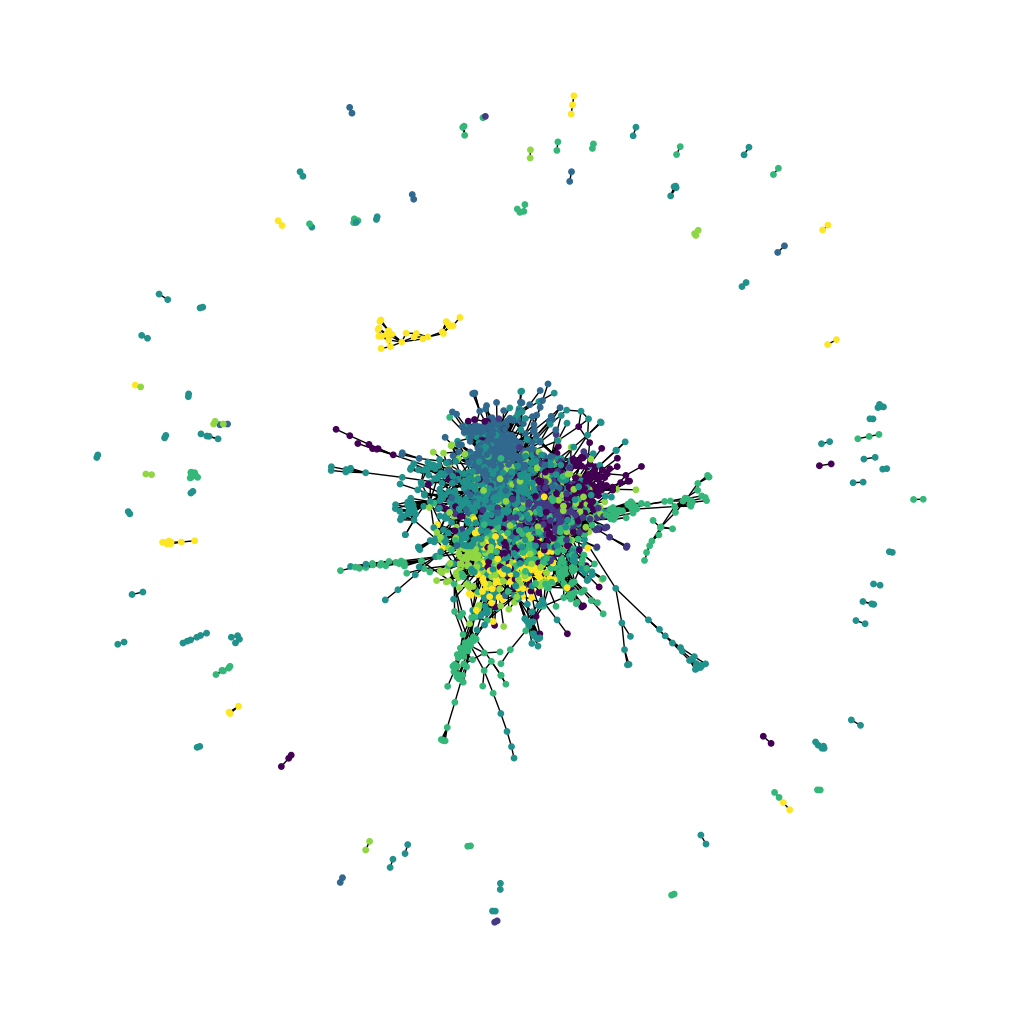

In [ ]:
# let's visualize the graph
from torch_geometric.utils import to_networkx

plt.figure(figsize=(10,10))
cora_nx = to_networkx(cora, to_undirected=True)
nx.draw(cora_nx, node_size=15, node_color=cora.y)

Okay, now it's time to set up a GCN using PyG! Reminder: we can construct a GNN in PyG similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's `GCNConv` implementing the graph convolution.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        return F.log_softmax(x, dim=1)

We're just trying to predict the right subject for each paper, hence the $\texttt{log_softmax}$ post-activation. This GCN is very similar to the [original implementation](https://github.com/tkipf/pygcn).

Let's take a look at the predictions of an untrained GCN by looking at a low dimensional representation:

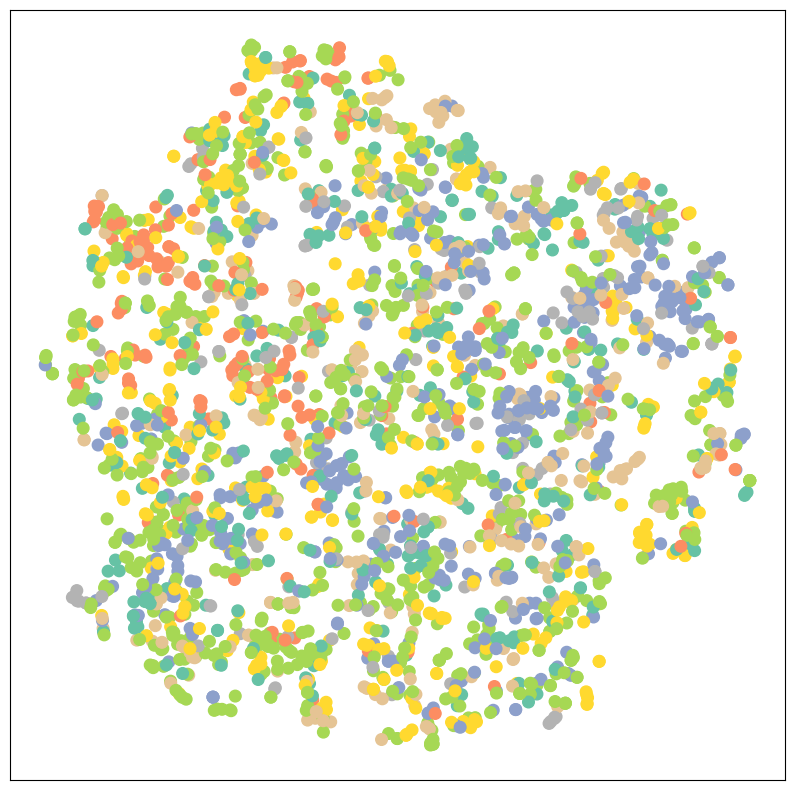

In [ ]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# examine the output of an untrained GCN
model = GCN()
model.eval()
out = model(cora)
visualize(out, color=cora.y)

Doesn't look like much, right? I guess we need to teach the GCN what to do!

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9539
Epoch: 002, Loss: 1.8310
Epoch: 003, Loss: 1.6923
Epoch: 004, Loss: 1.5433
Epoch: 005, Loss: 1.4060
Epoch: 006, Loss: 1.2431
Epoch: 007, Loss: 1.1191
Epoch: 008, Loss: 1.0052
Epoch: 009, Loss: 0.8989
Epoch: 010, Loss: 0.8179
Epoch: 011, Loss: 0.7246
Epoch: 012, Loss: 0.6084
Epoch: 013, Loss: 0.5146
Epoch: 014, Loss: 0.4839
Epoch: 015, Loss: 0.4563
Epoch: 016, Loss: 0.4031
Epoch: 017, Loss: 0.3695
Epoch: 018, Loss: 0.3060
Epoch: 019, Loss: 0.2714
Epoch: 020, Loss: 0.2959
Epoch: 021, Loss: 0.2273
Epoch: 022, Loss: 0.2123
Epoch: 023, Loss: 0.1731
Epoch: 024, Loss: 0.1775
Epoch: 025, Loss: 0.1534
Epoch: 026, Loss: 0.1870
Epoch: 027, Loss: 0.1252
Epoch: 028, Loss: 0.1124
Epoch: 029, Loss: 0.1284
Epoch: 030, Loss: 0.0998
Epoch: 031, Loss: 0.0796
Epoch: 032, Loss: 0.1042
Epoch: 033, Loss: 0.0866
Epoch: 034, Loss: 0.0730
Epoch: 035, Loss: 0.0821
Epoch: 036, Loss: 0.0790
Epoch: 037, Loss: 0.0661
Epoch: 038, Loss: 0.0704
Epoch: 039, Loss: 0.0545
Epoch: 040, Loss: 0.0566


In [ ]:
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7870


Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



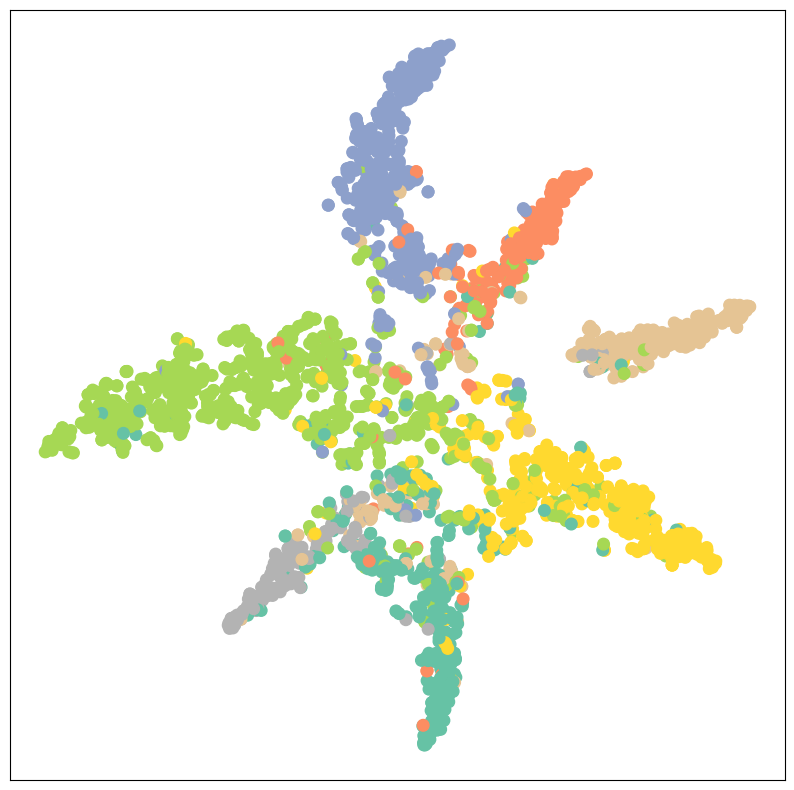

In [ ]:
model.eval()

out = model(cora)
visualize(out, color=cora.y)

**(Optional Exercise)** Play around with the training loop above! Some guiding questions:

- How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

- So far, we've just looked at GCNConv operations. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all GCNConv instances with GATConv layers that make use of attention? Try to write a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a dropout ratio of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head.

In [ ]:
# EXERCISE




In [ ]:
# EXERCISE




In [ ]:
# EXERCISE




# 2. (Optional Long Exercise) Graph-Level Training with ENZYMES
We've spent a lot of time on semi-supervised node classification, but what about graph classication in the sprit of the ENZYMES dataset? In this case, we don't want per-node outputs; we want one output vector per graph, giving the probabilities that the graph (enzyme) belongs to one of the classes (catalyst scores). Our GCN currently outputs 1 vector per node - we can *pool* these vectors, for example by averaging them, to produce 1 output vector for each graph. Once we normalize the output with `log_softmax`, it will represent classification scores for the entire graph. Here's your goal; modify the GCN above using [PyG global mean pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html) and re-train the GCN to predict classification scores on the ENZYMES dataset. The following cells will guide you through this:

In [ ]:
# load the dataset
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

enzymes = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
train_loader = DataLoader(enzymes[:400], batch_size=32, shuffle=True)
test_loader = DataLoader(enzymes[400:], shuffle=False)

**Exercise**: Apply `global_mean_pool` to `x`, fill in the proper dimensions for the convolution layers.


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.pool import global_mean_pool

class PoolingGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # EXERCISE: add the correct input and output dimensions:
        self.conv1 = GCNConv(, 512, cached=False)
        self.conv2 = GCNConv(512, , cached=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        #x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        # EXERCISE: global mean pool x

        return F.log_softmax(x, dim=1)

SyntaxError: ignored

**Exercise**: Here we've modified the training loop so that you can train your model. Modify the test loop similarly and evaluate the model's performance on the test set.



In [ ]:
model = PoolingGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train_step(train_loader):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss

def test_step(test_loader):
    model.eval()
    # EXERCISE: write a test step and evaluate your model

for epoch in range(1, 101):
    train_loss = train_step(train_loader)
    if not epoch%10:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}')

# Wrap Up
Nice! We've used PyG to build an effective GNN that re-embeds the initial Cora dataset graph into a space more useful for node label prediction. This is a just one of the many available GNN architectures and only one of the possible graph prediction tasks; other common tasks include edge classification and graph classification (check out this tutorial), among others.

In [ ]:
# answers to exercises:

# --- Cora Features Exercise ---
# sum(cora.train_mask)
# There are 140 training nodes, 20 from each of the 7 truth classes.
# This means overtraining is a real possibility and regularization will be important.

# --- Re-training GCN on Cora Exercise ---
# Adding more layers doesn't help too much (and even hurts if the network becomes too deep)!
# This is because node features get "washed out" across the graph.

# --- ENZYYMES Global Mean Pool Exercise ---
# 21 input features, 6 output classes
# x = global_mean_pool(x, data.batch)

# --- ENZYMES TRain Loop Exercise ---
# Just copy the train loop structure and the accuracy metric from the Cora train loop.
# But remember accuracy is computed per-graph now!